In [8]:
import json
import csv
import re
import subprocess
import logging
from datetime import datetime, date

NODE_PATH = "/opt/homebrew/bin/node"
JSSCRIPT_PATH = "./receiptsDownloader.js"
RECEIPTS_DIR = "./receipts/"

receipts_imported_file = "receipts_imported.json"
ph_output_file = "price_history.csv"
ib_output_file = "items_bought.csv"
cpm_output_file = "cost_per_month.csv"
    

In [9]:
output_filename = RECEIPTS_DIR + date.today().strftime("%m%d%Y")+ ".json"

try:
    result = subprocess.run([NODE_PATH, JSSCRIPT_PATH], capture_output=True, text=True, check=False) # capture_output and text are crucial

    if result.returncode == 0:
        try:
            with open(output_filename, "w") as f:
                f.write(result.stdout)
            print(f"Output written to {output_filename}")

        except Exception as e:
            logging.error(f"Error writing to file: {e}")

    else:
        error_message = f"JavaScript script returned a non-zero exit code: {result.returncode}\n"
        error_message += f"Stdout: {result.stdout}\n"
        error_message += f"Stderr: {result.stderr}"
        logging.warning(error_message)
        print(error_message) # Print to console as well for immediate feedback

except FileNotFoundError:
    logging.error(f"Node.js executable not found at: {NODE_PATH}")
    print(f"Error: Node.js executable not found at: {NODE_PATH}")
except Exception as e:
    logging.error(f"An error occurred during subprocess execution: {e}")
    print(f"Error: An error occurred during subprocess execution: {e}")


Output written to ./receipts/02012025.json


In [17]:
file_path = output_filename
stringified_json = None
with open(file_path, 'r', encoding='utf-8') as file:
    stringified_json = file.read()

# the input file must be a valid JSON with '\' removed
receipts = json.loads(stringified_json)['receipts']

In [18]:
def util_match_discount(string):
    pattern = r"/\s*(\d+)"
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    
def read_items_bought(csv_file):
    items_bought = {}
    try:
        with open(csv_file, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                itemNum = row['itemNum']
                items_bought[itemNum] = {
                    'itemDescription': row['itemDescription'],
                    'count': float(row['count']),
                    'cost': float(row['cost'])
                }
    except FileNotFoundError:
        print(f"{csv_file} not found. Starting with an empty dictionary.")
    return items_bought

def read_cost_per_month(csv_file):
    cost_per_month = {}
    try:
        with open(csv_file, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                month = row['month']
                price = float(row['price'])
                cost_per_month[month] = price
    except FileNotFoundError:
        print(f"{csv_file} not found. Starting with an empty dictionary.")
    return cost_per_month

def read_receipts_imported(json_file):
    with open(json_file, mode='r', encoding='utf-8') as file:
        return json.load(file)['receipts']


In [19]:
stores_visited = {}
price_history = {}
receipts_imported = []

try:
    cost_per_month = read_cost_per_month(cpm_output_file)
    items_bought= read_items_bought(ib_output_file)
    receipts_imported = read_receipts_imported(receipts_imported_file)
except FileNotFoundError:
    cost_per_month = {}
    items_bought = {}
    print("error: file not found")

for receipt in filter(lambda x: (x['receiptType'] == 'In-Warehouse') and 
                      (x['total']>0) and 
                      (x['transactionBarcode'] not in receipts_imported), receipts):
    print(receipt['transactionBarcode'])
    receipts_imported.append(receipt['transactionBarcode'])
    time = datetime.fromisoformat(receipt['transactionDateTime'])
    location = receipt['warehousePostalCode']
    # add stores visited
    warehouseName = receipt['warehouseName']
    if warehouseName not in stores_visited:
        stores_visited[warehouseName] = 1
    else :
        stores_visited[warehouseName] += 1
        
    item_list = receipt['itemArray']
    discounts = {}
    for item in filter(lambda x: x['unit']<0, item_list):
        # add discounts
        discount_item = util_match_discount(item['itemDescription01'])
        discount_amount = item['amount']/(-item['unit'])
        if discount_item not in discounts:
            discounts[discount_item] = abs(discount_amount)
            
    for item in filter(lambda x: x['unit']>0 and x['itemUnitPriceAmount']>0, item_list):
        # add items bought
        itemNum = item['itemNumber'] 
        cost = round(item['amount'] - (discounts[itemNum]*item['unit'] if itemNum in discounts else 0),3)
        count=round(item['amount']/item['itemUnitPriceAmount'],3)
        
        if itemNum not in items_bought:
            items_bought[itemNum] = {'itemDescription': item['itemDescription01'],'count': count, 'cost': cost}
        else:
            items_bought[itemNum]['count'] += count
            items_bought[itemNum]['cost'] += cost
            
        # add price history
        discount_entry = {
            'itemDescription': item['itemDescription01'],
            'time': receipt['transactionDateTime'],
            'location': location,
            'price': round(cost/count ,2)
        }
        
        price_history.setdefault(itemNum, []).append(discount_entry)
    month_year = f"{time.month}/{time.year}"
    cost_per_month[month_year] = cost_per_month.get(month_year, 0) + receipt['subTotal']
    

In [20]:
with open(receipts_imported_file, mode='w', newline='', encoding='utf-8') as file:
    json.dump({"receipts":receipts_imported}, file)

In [13]:
# Append to the CSV file
with open(ph_output_file, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Append the data rows
    for itemNum, entries in price_history.items():
        for entry in entries:
            writer.writerow([
                itemNum,
                entry['itemDescription'],
                entry['time'],
                entry['location'],
                entry['price']
            ])

In [14]:
# Write to CSV
with open(ib_output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['itemNum', 'itemDescription', 'count', 'cost'])

    # Write the data rows
    for itemNum, details in items_bought.items():
        writer.writerow([
            itemNum,
            details['itemDescription'],
            details['count'],
            details['cost'], 
        ])

In [15]:
with open(cpm_output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(['month', 'price'])
        # Write the data rows
        for month, price in cost_per_month.items():
            writer.writerow([month, price])

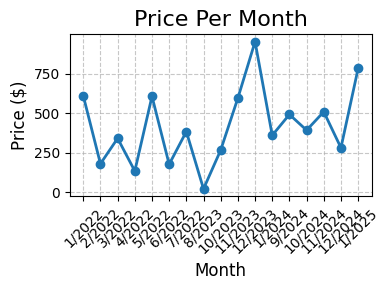

In [16]:
import matplotlib.pyplot as plt
months = list(cost_per_month.keys())[::-1]
prices = list(cost_per_month.values())[::-1]
# Create the plot
plt.figure(figsize=(4, 3))
plt.plot(months, prices, marker='o', linestyle='-', linewidth=2)
plt.title('Price Per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

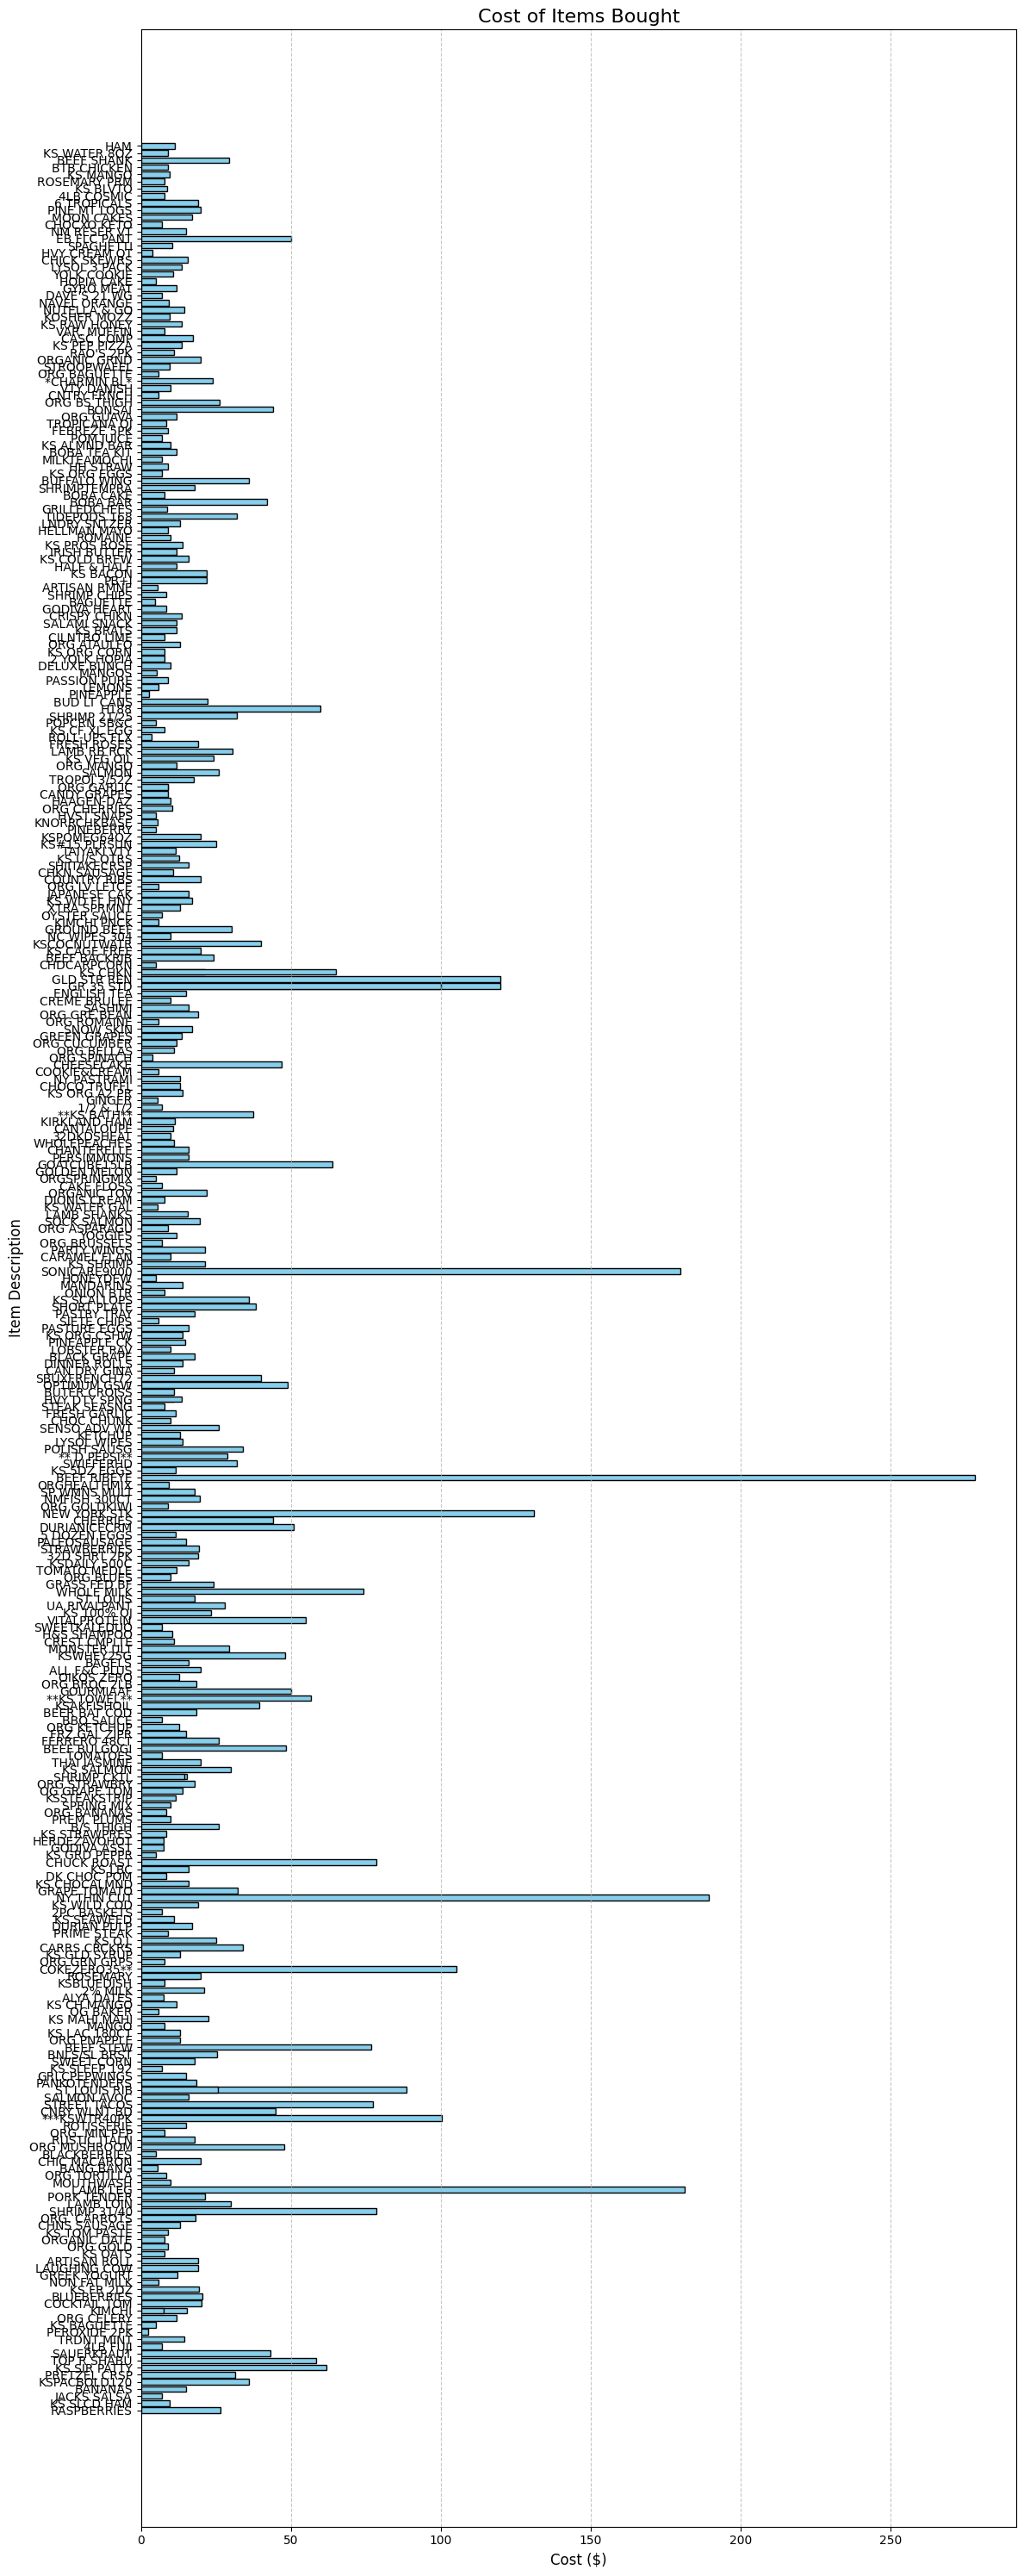

In [9]:
item_descriptions = [details['itemDescription'] for details in items_bought.values()]
costs = [details['cost'] for details in items_bought.values()]

# Create the plot
plt.figure(figsize=(12, 30))
plt.barh(item_descriptions, costs, color='skyblue', edgecolor='black')
plt.title('Cost of Items Bought', fontsize=16)
plt.xlabel('Cost ($)', fontsize=12)
plt.ylabel('Item Description', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()